<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [48]:
import sys
import os
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'Utils')
sys.path.append(utils_directory)

import numpy as np
import pandas as pd
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# Warning
import warnings
warnings.filterwarnings("ignore")
from Utils.DNA_Utils import DNA

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [49]:
#dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
dataset_ = pd.read_csv("./Output/kiwi_orange_cds.csv")

# Split
dataset, testset = train_test_split(dataset_, test_size=0.2, stratify=dataset_["class"], random_state=42)
dataset = dataset.reset_index(drop=True)
testset = testset.reset_index(drop=True)

# Get a look
dataset.head()

,id,sequence,length,class
0,orange1.1g020389m Citrus sinensis,ATGGTATCAAAAATCCCGAACCCGGCAGAAGGATTCTACTTGGATC...,984,0
1,orange1.1g046419m Citrus sinensis,ATGCTGTTGGGGAACAGCAACGGAGAGCAACTGGAAAGCGGGGTTG...,1518,0
2,orange1.1g007034m Citrus sinensis,ATGATGATGAGTTTTGATGAGATGGGGTTTTGTGGTGACATGAACT...,1866,0
3,Achn378631 Actinidia chinensis,ATGGCAGGTTTTGAAATGGCAGGGGAACCCAAGATTGATGAGGTAA...,783,1
4,Achn155941 Actinidia chinensis,ATGCCCAATTTCATTCCAACAGTTGTGTTTGTTGCTCCTCACCTCA...,777,1


### 3 - Preprocessing and Model Utils
Instead of taking each base as an individual feature, we transform DNA sequences using the k-mer representation, a widely adopted method in DNA sequence analysis. The k-mer approach captures richer contextual information for each nucleotide by concatenating it with its subsequent bases to form k-mers. For example, the DNA sequence ‘ATGCCA’ can be tranformed into four 3-mers: "ATG, TGC, GCC, CCA", or into three 4-mers: "ATGC, TGCC, GCCA". In our experiments, we will try these k-mer length: **3, 4, 5, and 6**.

* Utils

In [50]:
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/DeepFeedFw/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], '.-', label=m, lw=2, )
    plt.legend()

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [27]:
k = 3
X_train, y_train = DNA.build_kmer_representation(dataset, k=k)
X_test, y_test = DNA.build_kmer_representation(testset, k=k)
X_test.head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0.022687,0.013790,0.028470,0.025801,0.014235,0.008007,0.005338,0.012456,0.035142,0.015125,...,0.004448,0.021797,0.033808,0.015569,0.020018,0.020463,0.014235,0.020018,0.024911,0.028915
1,0.009472,0.016238,0.017591,0.009472,0.013532,0.024357,0.013532,0.016238,0.018945,0.009472,...,0.018945,0.024357,0.014885,0.014885,0.017591,0.008119,0.005413,0.027064,0.013532,0.009472
2,0.018137,0.018961,0.020610,0.014839,0.015664,0.020610,0.005771,0.021434,0.018137,0.018137,...,0.006595,0.023908,0.026381,0.018961,0.016488,0.008244,0.009068,0.032152,0.009893,0.023908
3,0.045161,0.018065,0.028387,0.019355,0.010323,0.009032,0.016774,0.010323,0.037419,0.018065,...,0.011613,0.006452,0.021935,0.009032,0.029677,0.009032,0.011613,0.003871,0.016774,0.014194
4,0.024480,0.018360,0.037944,0.023256,0.029376,0.009792,0.006120,0.007344,0.039168,0.026928,...,0.002448,0.013464,0.026928,0.020808,0.018360,0.011016,0.006120,0.020808,0.017136,0.014688


In [28]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = 4**k

X_train: (3640, 64)
X_test: (911, 64)
y_train: (3640,)
y_test: (911,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,905 (234.00 KB)

 Trainable params: 59,905 (234.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5118 - loss: 0.6926 - val_accuracy: 0.5041 - val_loss: 0.6885
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5958 - loss: 0.6769 - val_accuracy: 0.6264 - val_loss: 0.6299
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6794 - loss: 0.6105 - val_accuracy: 0.7527 - val_loss: 0.5177
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7437 - loss: 0.5367 - val_accuracy: 0.7692 - val_loss: 0.4908
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7714 - loss: 0.5008 - val_accuracy: 0.7418 - val_loss: 0.5238
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7635 - loss: 0.5195 - val_accuracy: 0.7665 - val_loss: 0.4809
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7868 - loss: 0.4934 - val_accuracy: 0.7637 - val_loss: 0.4721
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7840 - loss: 0.4718 - val_accuracy: 0.7898 - v

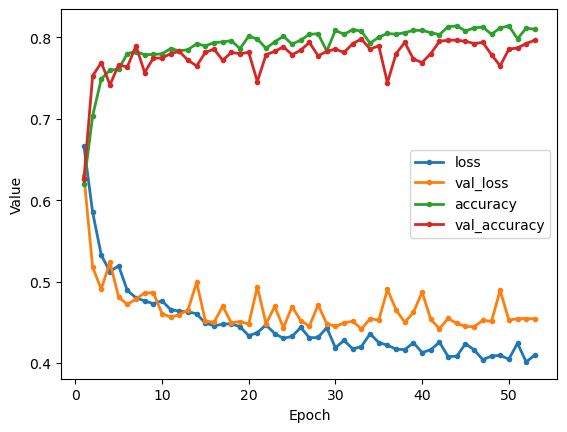

In [29]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("Test Accuracy: {:.2f}%]".format(test_scores[1]*100)) #\n[Train Accuracy: {:.2f}% - 
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [67]:
k = 4
X_train, y_train = DNA.build_kmer_representation(dataset, k=k)
X_test, y_test = DNA.build_kmer_representation(testset, k=k)
X_test.head()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.004450,0.004895,0.007566,0.005785,0.004450,0.002225,0.001780,0.005340,0.009346,0.007121,...,0.001780,0.009791,0.008901,0.004450,0.002670,0.008901,0.007121,0.005340,0.009346,0.007121
1,0.001355,0.005420,0.001355,0.001355,0.006775,0.005420,0.000000,0.004065,0.006775,0.001355,...,0.004065,0.005420,0.005420,0.002710,0.004065,0.001355,0.001355,0.004065,0.001355,0.002710
2,0.006601,0.001650,0.005776,0.004125,0.004950,0.006601,0.001650,0.005776,0.005776,0.004950,...,0.001650,0.012376,0.004125,0.002475,0.001650,0.001650,0.004950,0.009901,0.004125,0.004950
3,0.018088,0.009044,0.011628,0.006460,0.003876,0.005168,0.006460,0.002584,0.012920,0.007752,...,0.001292,0.001292,0.003876,0.001292,0.009044,0.002584,0.005168,0.001292,0.005168,0.002584
4,0.007353,0.006127,0.006127,0.004902,0.015931,0.000000,0.001225,0.001225,0.012255,0.009804,...,0.001225,0.006127,0.007353,0.004902,0.002451,0.002451,0.001225,0.002451,0.007353,0.003676


In [68]:
NUM_CLASS  = 1
SEQ_LENGTH = 4**k

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 192)            │        49,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 160)            │        30,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 96)             │        15,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,777 (374.13 KB)

 Trainable params: 95,777 (374.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5326 - loss: 0.6903 - val_accuracy: 0.6593 - val_loss: 0.6469
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7189 - loss: 0.6047 - val_accuracy: 0.7679 - val_loss: 0.5110
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7463 - loss: 0.5172 - val_accuracy: 0.7788 - val_loss: 0.4529
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7950 - loss: 0.4425 - val_accuracy: 0.7940 - val_loss: 0.4397
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7825 - loss: 0.4667 - val_accuracy: 0.8104 - val_loss: 0.4148
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8066 - loss: 0.4156 - val_accuracy: 0.8036 - val_loss: 0.4095
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8250 - loss: 0.3987 - val_accuracy: 0.8036 - val_loss: 0.4106
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8298 - loss: 0.3960 - val_accuracy: 0.8118 - v

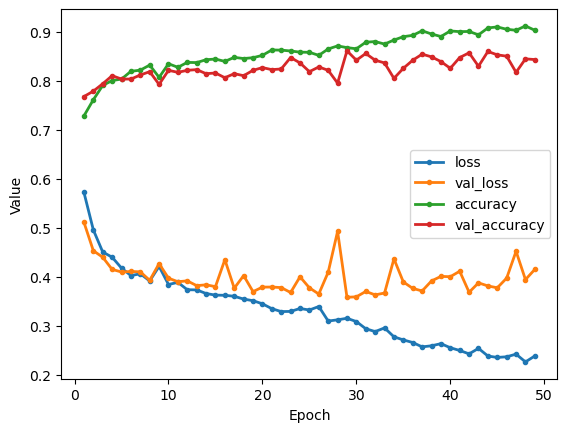

In [69]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(192, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(96, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\nTest Accuracy: {:.2f}%]".format(test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [70]:
k = 5
X_train, y_train = DNA.build_kmer_representation(dataset, k=k)
X_test, y_test = DNA.build_kmer_representation(testset, k=k)
X_test.head()

,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.001336,0.000890,0.001336,0.000890,0.001781,0.001336,0.000890,0.000890,0.001336,0.001336,...,0.000445,0.002226,0.002671,0.001781,0.001336,0.003562,0.002226,0.001781,0.001781,0.001336
1,0.000000,0.000000,0.001357,0.000000,0.001357,0.002714,0.000000,0.001357,0.000000,0.000000,...,0.000000,0.001357,0.001357,0.000000,0.000000,0.000000,0.001357,0.001357,0.000000,0.000000
2,0.001652,0.000826,0.002477,0.001652,0.000000,0.000826,0.000000,0.000826,0.001652,0.001652,...,0.000000,0.002477,0.002477,0.000826,0.000000,0.000826,0.002477,0.000000,0.001652,0.000826
3,0.003881,0.005175,0.006468,0.002587,0.002587,0.002587,0.003881,0.000000,0.003881,0.005175,...,0.000000,0.001294,0.000000,0.001294,0.001294,0.002587,0.001294,0.000000,0.001294,0.000000
4,0.000000,0.001227,0.003681,0.002454,0.004908,0.000000,0.001227,0.000000,0.002454,0.001227,...,0.000000,0.002454,0.001227,0.003681,0.001227,0.001227,0.001227,0.000000,0.002454,0.000000


In [71]:
NUM_CLASS  = 1
SEQ_LENGTH = 4**k

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,617 (1.16 MB)

 Trainable params: 303,617 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5253 - loss: 0.6915 - val_accuracy: 0.7445 - val_loss: 0.6611
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7122 - loss: 0.6189 - val_accuracy: 0.7555 - val_loss: 0.4853
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7725 - loss: 0.4766 - val_accuracy: 0.8146 - val_loss: 0.4162
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8237 - loss: 0.3972 - val_accuracy: 0.8338 - val_loss: 0.3855
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8574 - loss: 0.3508 - val_accuracy: 0.8091 - val_loss: 0.4052
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8639 - loss: 0.3325 - val_accuracy: 0.8228 - val_loss: 0.3900
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8603 - loss: 0.3318 - val_accuracy: 0.8242 - val_loss: 0.3880
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8647 - loss: 0.3144 - val_accuracy: 0.8338 - v

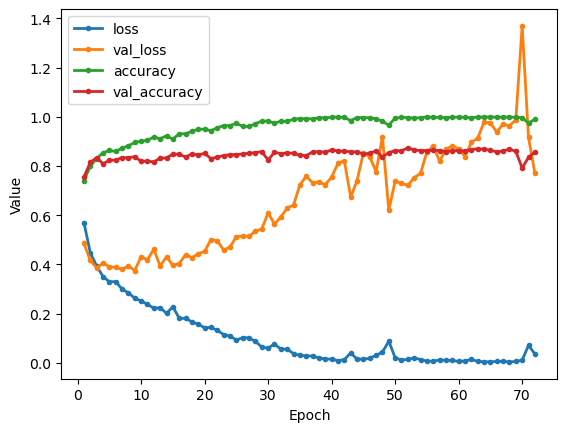

In [39]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=6</li></ul>
</h4>

In [14]:
k = 6
X_train, y_train = DNA.build_kmer_representation(dataset, k=k)
X_test, y_test = DNA.build_kmer_representation(testset, k=k)
X_test.head()

,AAAAAA,AAAAAC,AAAAAG,AAAAAT,AAAACA,AAAACC,AAAACG,AAAACT,AAAAGA,AAAAGC,...,TTTTCG,TTTTCT,TTTTGA,TTTTGC,TTTTGG,TTTTGT,TTTTTA,TTTTTC,TTTTTG,TTTTTT
0,0.000445,0.0,0.000000,0.000891,0.000000,0.000445,0.000445,0.0,0.000445,0.000000,...,0.000445,0.000445,0.000000,0.000445,0.000445,0.000891,0.000445,0.000445,0.000445,0.0
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.000826,0.000826,0.000000,0.000826,0.000000,0.0,0.000826,0.000000,...,0.000000,0.000000,0.000826,0.000826,0.000000,0.000000,0.000826,0.000000,0.000000,0.0
3,0.000000,0.0,0.002591,0.001295,0.002591,0.000000,0.002591,0.0,0.001295,0.002591,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001295,0.000000,0.000000,0.000000,0.0
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.001229,0.0,0.002457,0.000000,...,0.000000,0.000000,0.001229,0.000000,0.000000,0.001229,0.000000,0.000000,0.000000,0.0


In [15]:
NUM_CLASS  = 1
SEQ_LENGTH = 4**k

* <span style="color: blue; font-weight: bold;">MODEL 4 : FEED-FORWARD NETWORKS</span>

Model: "FEEDFORWARD_k6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090,049 (4.16 MB)

 Trainable params: 1,090,049 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5178 - loss: 0.6918 - val_accuracy: 0.6676 - val_loss: 0.6684
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7522 - loss: 0.6128 - val_accuracy: 0.7995 - val_loss: 0.4572
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8313 - loss: 0.3949 - val_accuracy: 0.8255 - val_loss: 0.4057
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8764 - loss: 0.2922 - val_accuracy: 0.8681 - val_loss: 0.3281
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9227 - loss: 0.2118 - val_accuracy: 0.8709 - val_loss: 0.3250
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9549 - loss: 0.1429 - val_accuracy: 0.8681 - val_loss: 0.3349
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9624 - loss: 0.1119 - val_accuracy: 0.8750 - val_loss: 0.3530
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9856 - loss: 0.0611 - val_accuracy: 0.

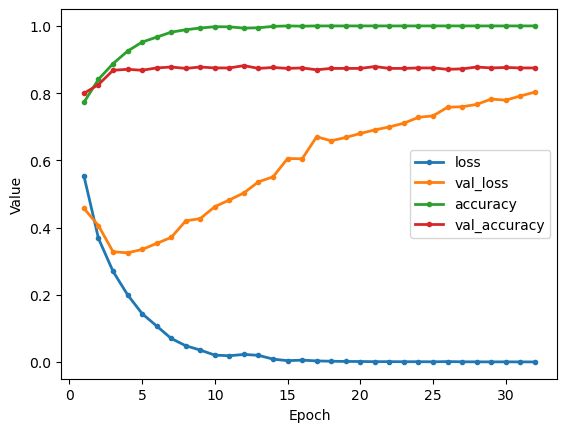

In [16]:
name="FEEDFORWARD_k6"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<div style="background-color: #80c4e6; padding: 0.5em;">
    <b>RECAP</b>: BEST MODEL FOUND
    
    * k = 6, acc: 96.05%
    
</div>

try tuning model

In [ ]:
**

In [72]:
import keras_tuner

In [73]:
def build_model(hp):
    model = tf.keras.Sequential(name="SEARCH_ARCH")
    model.add(Input(shape=(SEQ_LENGTH,)))

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            tf.keras.layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                activation=hp.Choice("activation", ["relu"]),
            )
        )
        #model.add(Dropout(rate=0.2))
        #if hp.Boolean("dropout"):
        model.add(tf.keras.layers.Dropout(
                rate=hp.Float('rate', min_value = 0.2, max_value = 0.5, step = 0.1),
            )
        )

    # Keep last layers without tuning
    model.add(tf.keras.layers.Dense(NUM_CLASS, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Tune learning rate
    #model.compile(
    #    optimizer=tf.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=3e-3, max_value=0.2, sampling="linear")),
    #    loss="categorical_crossentropy",
    #    metrics=["accuracy"],
    #)
    return model

build_model(keras_tuner.HyperParameters())

<Sequential name=SEARCH_ARCH, built=True>

In [76]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory="/tmp/tb_logs",
    project_name="lab3_search",
)

# See summary
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [ ]:
stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=5,
    verbose=0,
)

# Start search
tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    callbacks=[stop_callback, tf.keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

# Get the best model
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.build()
best_model.summary()

# Let's report the performance on test set
test_score = best_model.evaluate(
    x=X_test,
    y=y_test,
    batch_size=32,
    verbose=False,
    return_dict=True
)
print(f"\nTUNED_MODEL_TESTSET(LOSS={test_score['loss']} and ACCURACY={test_score['accuracy']})\n")

Trial 80 Complete [00h 00m 49s]
val_accuracy: 0.8530219793319702

Best val_accuracy So Far: 0.8777472376823425
Total elapsed time: 00h 35m 20s

Search: Running Trial #81

Value             |Best Value So Far |Hyperparameter
1                 |3                 |num_layers
32                |256               |units_0
relu              |relu              |activation
0.3               |0.2               |rate
160               |96                |units_1
96                |256               |units_2

Epoch 1/30
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5824 - loss: 0.6918 

In [66]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs